In [1]:
from pathlib import Path
import polars as pl

from typing import Optional

import logging

from datetime import datetime


def _drop_nulls(df: pl.DataFrame, df_name: str, col_names: Optional[list[str]] = None) -> pl.DataFrame:
    """ Drop null rows in df with logging

    Args:
        df (pl.DataFrame): 
        df_name (str): 
        col_names (Optional[list[str]], optional): select columns to check for nulls. Defaults to None.

    Returns:
        pl.DataFrame: _description_
    """
    len_df = len(df)
    df = df.drop_nulls(subset=col_names)
    len_dropped_df = len(df)
    if len_df != len_dropped_df:
        logging.warning(f"Dropped {len_df - len_dropped_df} null rows from {df_name} dataframe")
    return df

    
def _filter_on_timestamp(df: pl.DataFrame,
                         df_name: str,
                         ts_col: str,
                         min_ts: Optional[datetime] = None,
                         max_ts: Optional[datetime] = None) -> pl.DataFrame:
    # filter on min_ts
    if min_ts is not None:
        len_df = len(df)
        df = df.filter(pl.col(ts_col) >= min_ts)
        len_filtered_df = len(df)
        if len_df != len_filtered_df:
            logging.warning(f"Filtered out {len_df - len_filtered_df} rows from {df_name} before min_ts {min_ts}")
    # filter on max_ts
    if max_ts is not None:
        len_df = len(df)
        df = df.filter(pl.col(ts_col) <= max_ts)
        len_filtered_df = len(df)
        if len_df != len_filtered_df:
            logging.warning(f"Filtered out {len_df - len_filtered_df} rows from {df_name} after max_ts {max_ts}")

    return df


In [2]:
# Ingest functions for each dataframe

def _ingest_app_usage(file_path: Path,
                       min_ts: Optional[datetime] = None,
                       max_ts: Optional[datetime] = None) -> pl.DataFrame:
    
    df = pl.read_csv(file_path, columns=['member_id', 'timestamp']) # event_type is all 'session', don't load it
    
    df = _drop_nulls(df, 'app_usage')  # currently use all columns, the data doesn't contain nulls anyway
    
    df = df.with_columns(
        pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
    )
    
    # filter timestamp range
    df = _filter_on_timestamp(df, 'app_usage', 'timestamp', min_ts, max_ts)
    
    df = df.sort(by=['member_id', 'timestamp'])
    
    return df


def _ingest_churn_labels(file_path: Path, 
                         min_ts: Optional[datetime] = None,
                         max_ts: Optional[datetime] = None) -> pl.DataFrame:
    df = pl.read_csv(file_path)
    df = _drop_nulls(df, 'churn_labels')  
    
    df = df.with_columns(
        pl.col("signup_date").str.strptime(pl.Datetime, "%Y-%m-%d")
    )
    
    # no timestamp filtering for churn_labels as it only has signup_date
    
    return df


def _ingest_claims(file_path: Path,
                   min_ts: Optional[datetime] = None,
                   max_ts: Optional[datetime] = None) -> pl.DataFrame:
    df = pl.read_csv(file_path)
    df = _drop_nulls(df, 'claims')  # currently use all columns, the data doesn't contain nulls anyway
    
    df = df.with_columns(
        pl.col("diagnosis_date").str.strptime(pl.Datetime, "%Y-%m-%d")
    )
    # filter timestamp range
    df = _filter_on_timestamp(df, 'claims', 'diagnosis_date', min_ts, max_ts)
    
    df.sort(by=['member_id', 'diagnosis_date'])
    return df


def _ingest_web_visits(file_path: Path,
                       min_ts: Optional[datetime] = None,
                       max_ts: Optional[datetime] = None) -> pl.DataFrame:

    relevant_website_titles = ['Healthy eating guide',
                        'Mediterranean diet',
                        'Restorative sleep tips',
                        'Aerobic exercise',
                        'Cardiometabolic health',
                        'Weight management',
                        'Stress reduction',
                        'Sleep hygiene',
                        'HbA1c targets',
                        'Cardio workouts',
                        'High-fiber meals',
                        'Cholesterol friendly foods',
                        'Hypertension basics',
                        'Meditation guide',
                        'Exercise routines',
                        'Diabetes management',
                        'Lowering blood pressure',
                        'Strength training basics',
                        ]
    relevant_columns = ['member_id', 'timestamp', 'title']  # don't use url or description for now
    
    df = pl.read_csv(file_path, columns=relevant_columns)
    
    df = _drop_nulls(df, 'web_visits')  # currently use all columns, the data doesn't contain nulls anyway
    df = df.filter(pl.col("title").is_in(relevant_website_titles))
    
    # convert str to datetime
    df = df.with_columns(
        pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
    )
    df.sort(by=['member_id', 'timestamp'])
    
    return df

# dict of processing functions for each dataframe, keyed by csv name (e.g. 'app_usage')
ingest_functions = {
    'app_usage': _ingest_app_usage,
    'churn_labels': _ingest_churn_labels,
    'claims': _ingest_claims,
    'web_visits': _ingest_web_visits,
}

def ingest_and_pre_process_data(folder_path: str | Path, 
                    min_ts: Optional[datetime] = None,
                    max_ts: Optional[datetime] = None) -> dict[str, pl.DataFrame]:
    """ Pre-process each df with function based on the csv name.
        Turn str columns to datetime, drop nulls, sort by member_id and timestamp/diagnosis_date
        Select in date range

    Args:
        folder_path: path with all csv files
        min_ts (Optional[datetime], optional): minimum ts to filter on. Defaults to None.
        max_ts (Optional[datetime], optional): maximum ts to filter on. Defaults to None

    Returns:
        dict[str, pl.DataFrame]: preprocessed dict of dataframes, keyed by csv name (e.g. 'app_usage')
    """
    
    folder_path = Path(folder_path)
    dfs = dict()
    
    logging.info(f"Ingesting and pre-processing dataframes from folder: {folder_path}")
    
    for file_path in folder_path.glob('*.csv'):
        file_stem = file_path.stem.replace('train_', '')  # remove 'train_' prefix to unify naming convention
        name = file_stem  # use file_stem as the name key
        
        if name in ingest_functions:
            dfs[name] = ingest_functions[name](file_path, min_ts, max_ts)
        else:
            logging.warning(f"No ingest function defined for {name}, ingesting without processing")
            dfs[name] = pl.read_csv(file_path)
                
    return dfs

In [3]:
import polars as pl
from datetime import datetime

obs_window_end = datetime(2025, 7, 16)  # start of day after end of observation window


def featurize_data(dfs: dict[str, pl.DataFrame]) -> pl.DataFrame:
    """ Takes all loaded df-s and outputs a single df with all engineered features. 

    Args:
        dfs (dict[str, pl.DataFrame]): _description_

    Returns:
        pl.DataFrame: _description_
    """
    # Placeholder for feature engineering logic
    # This function would combine and transform the processed dataframes into a single feature set
    features_w_labels = dfs['churn_labels'].clone()
    
    # Feature set 1: claims features 
    # ------------------------------
    
    # group claims by member_id and icd_code to get first and last diagnosis dates and number of diagnoses
    claims_per_id = dfs['claims'].group_by(
    ['member_id', 'icd_code']).agg(
        pl.min('diagnosis_date').alias('first_dx_date'),
        pl.max('diagnosis_date').alias('last_dx_date'),
        pl.count('diagnosis_date').alias('dx_count')
    )

    # diff from obs_window_end, in days
    claims_per_id = claims_per_id.with_columns(
        (obs_window_end - pl.col("first_dx_date")).dt.total_days().alias("first_dx_dt"),
        (obs_window_end - pl.col("last_dx_date")).dt.total_days().alias("last_dx_dt"),
    )
    # pivot to use as columns    
    claims_per_id = claims_per_id.pivot(values=['dx_count', 'first_dx_dt', 'last_dx_dt'],
                                        index='member_id',
                                        on='icd_code').fill_null(0)
    
    features_w_labels = features_w_labels.join(claims_per_id, on='member_id', how='left')
    
    # Feature set 2: app usage features
    # ---------------------------------
    
    
    return features_w_labels

In [3]:
from pathlib import Path
dfs = ingest_and_pre_process_data(Path('./data/train'))


In [10]:
dfs['app_usage'].with_columns(pl.lit('app_usage').alias('event'))
dfs['claims'].with_columns(pl.lit('claims').alias('event'))
dfs['web_visits'].with_columns(pl.lit('web_visits').alias('event'))

dfs['claims'] = dfs['claims'].with_columns(pl.col('diagnosis_date').dt.date().alias('date'))
dfs['web_visits'] = dfs['web_visits'].with_columns(pl.col('timestamp').dt.date().alias('date'))
dfs['app_usage'] = dfs['app_usage'].with_columns(pl.col('timestamp').dt.date().alias('date'))


events = pl.concat([df for key, df in dfs.items() if key in ['app_usage', 'claims', 'web_visits']], how='diagonal')



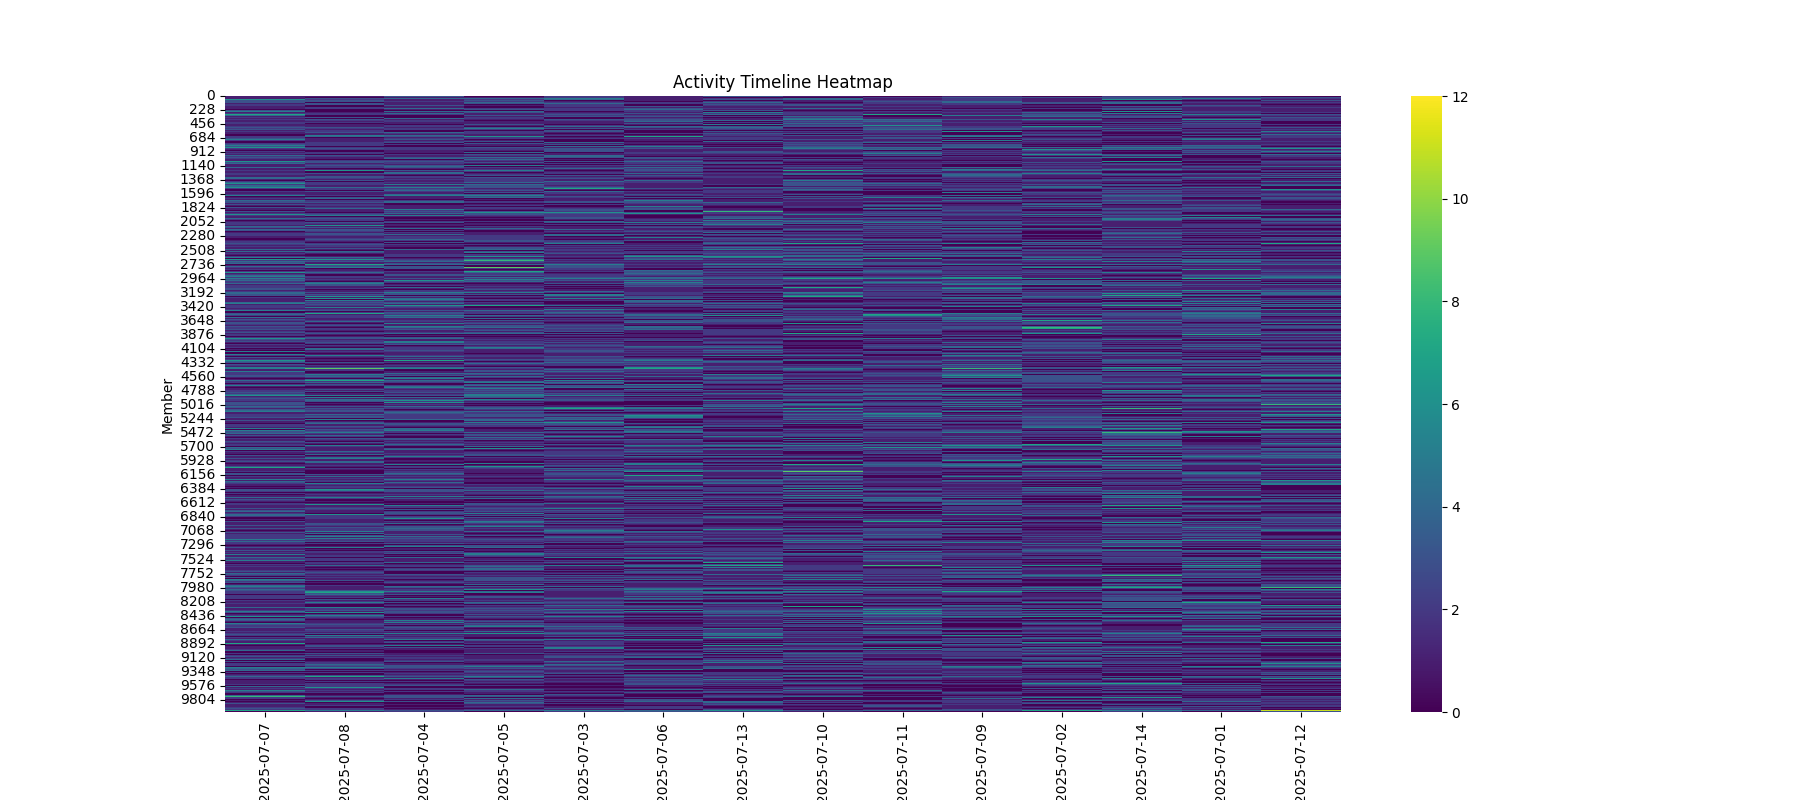

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

daily = (
    events.group_by(['member_id', 'date']).agg(pl.len().alias("count"))
)

heatmap_df = (
    daily.pivot(values="count", index="member_id", on="date")
    .fill_null(0)
    .to_pandas()
    .drop(columns=['member_id'])
)


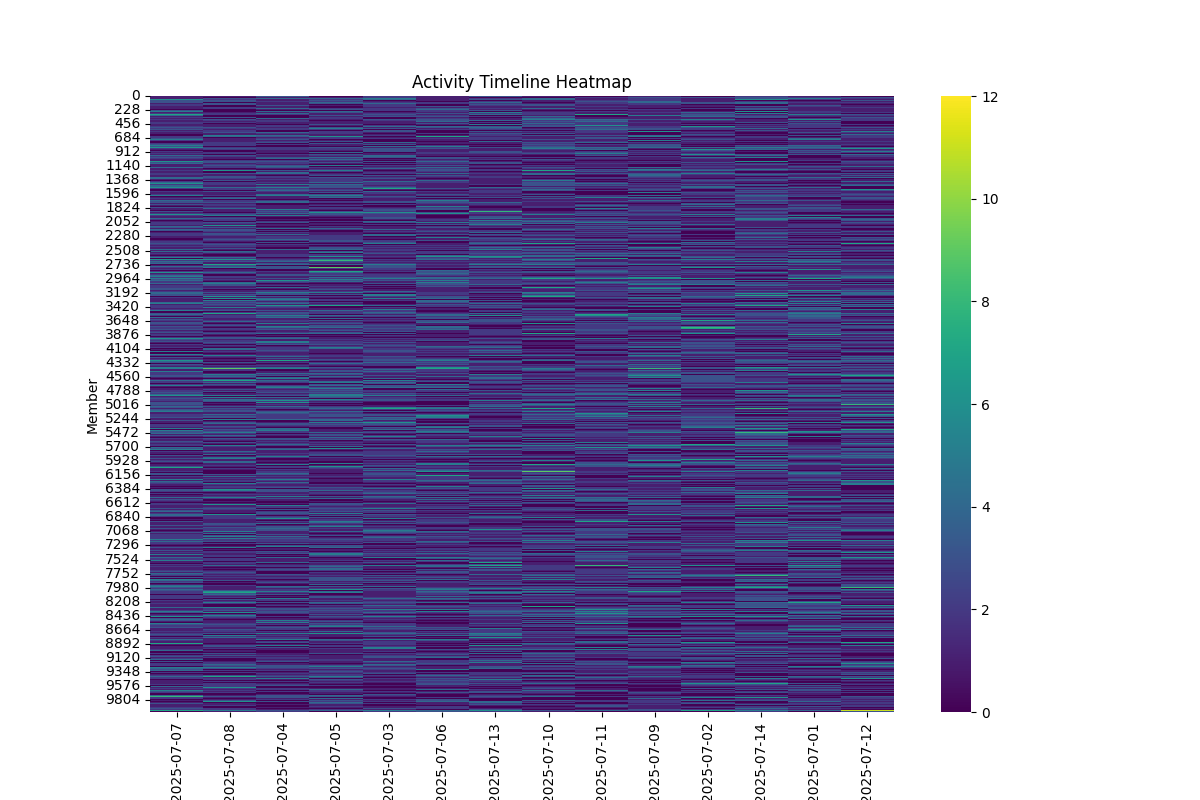

In [22]:

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="viridis")
plt.title("Activity Timeline Heatmap")
plt.xlabel("Date")
plt.ylabel("Member")
# plt.axis('equal')

plt.show()

In [6]:
import pandas as pd

events_df = events.to_pandas()
app_usage_df = dfs['app_usage'].to_pandas()
claims_df = dfs['claims'].to_pandas()
web_visits_df = dfs['web_visits'].to_pandas()

In [ ]:
[df.describe() for df in dfs.values()]

In [71]:
obs_window_end = datetime(2025, 7, 16)  # start of day after end of observation window

features_w_labels = dfs['churn_labels'].clone()

features_w_labels = features_w_labels.with_columns(
    (obs_window_end - pl.col("signup_date")).dt.total_days().alias("signup_date_dt")
)
features_w_labels = features_w_labels.drop('signup_date')

In [72]:
##
# Feature set 1: claims features
# group claims by member_id and icd_code to get first and last diagnosis dates and number of diagnoses
claims_per_id = dfs['claims'].group_by(
    ['member_id', 'icd_code']).agg(
        pl.min('diagnosis_date').alias('first_dx_date'),
        pl.max('diagnosis_date').alias('last_dx_date'),
        pl.count('diagnosis_date').alias('dx_count')
)

# diff from obs_window_end, in days
claims_per_id = claims_per_id.with_columns(
    (obs_window_end - pl.col("first_dx_date")).dt.total_days().alias("first_dx_dt"),
    (obs_window_end - pl.col("last_dx_date")).dt.total_days().alias("last_dx_dt"),
)
# pivot to use each claim icd_code's min/max/count as column    
claims_per_id = claims_per_id.pivot(values=['dx_count', 'first_dx_dt', 'last_dx_dt'],
                                    index='member_id',
                                    on='icd_code').fill_null(0)


In [73]:
# join with claims features

features_w_labels = features_w_labels.join(claims_per_id, on='member_id', how='left')

# fill nulls after join

features_w_labels = features_w_labels.with_columns(
    pl.col(r"^dx_count_.*$").fill_null(0),
    pl.col(r"^first_dx_dt.*$").fill_null(1e5),
    pl.col(r"^last_dx_dt.*$").fill_null(1e5),
)

In [74]:
##
# Feature set 2: web_visits features

# group only by member id to get first and last web_visit dates and number of web_visits
web_visits_per_id = dfs['web_visits'].group_by(
    ['member_id']).agg(
        pl.min('timestamp').alias('first_wv_date'),
        pl.max('timestamp').alias('last_wv_date'),
        pl.count('timestamp').alias('wv_count')
)

# diff from obs_window_end, in days
web_visits_per_id = web_visits_per_id.with_columns(
    (obs_window_end - pl.col("first_wv_date")).dt.total_days().alias("first_wv_dt"),
    (obs_window_end - pl.col("last_wv_date")).dt.total_days().alias("last_wv_dt"),
)


web_visits_per_id = web_visits_per_id[['member_id', 'wv_count', 'first_wv_dt', 'last_wv_dt']]

In [75]:
features_w_labels = features_w_labels.join(web_visits_per_id, on='member_id', how='left')

features_w_labels = features_w_labels.with_columns(
    pl.col("wv_count").fill_null(0),
    pl.col("first_wv_dt").fill_null(1e5),
    pl.col("last_wv_dt").fill_null(1e5),
)

In [76]:
##
# Feature set3: app_usage
# group app_usage by member_id to get first and last app usage and number of app usages
app_usage_per_id = dfs['app_usage'].group_by(
    ['member_id']).agg(
        pl.min('timestamp').alias('first_au_date'),
        pl.max('timestamp').alias('last_au_date'),
        pl.count('timestamp').alias('au_count')
)

# diff from obs_window_end, in days
app_usage_per_id = app_usage_per_id.with_columns(
    (obs_window_end - pl.col("first_au_date")).dt.total_days().alias("first_au_dt"),
    (obs_window_end - pl.col("last_au_date")).dt.total_days().alias("last_au_dt"),
)

app_usage_per_id = app_usage_per_id[['member_id', 'au_count', 'first_au_dt', 'last_au_dt']]

In [77]:
features_w_labels = features_w_labels.join(app_usage_per_id, on='member_id', how='left')

features_w_labels = features_w_labels.with_columns(
    pl.col("au_count").fill_null(0),
    pl.col("first_au_dt").fill_null(1e5),
    pl.col("last_au_dt").fill_null(1e5),
)

In [78]:
# use as test
features_w_labels.filter(pl.any_horizontal(pl.all().is_null()))

member_id,churn,outreach,signup_date_dt,dx_count_K21.9,dx_count_R51,dx_count_H10.9,dx_count_M54.5,dx_count_B34.9,dx_count_I10,dx_count_Z71.3,dx_count_E11.9,dx_count_A09,dx_count_J00,first_dx_dt_K21.9,first_dx_dt_R51,first_dx_dt_H10.9,first_dx_dt_M54.5,first_dx_dt_B34.9,first_dx_dt_I10,first_dx_dt_Z71.3,first_dx_dt_E11.9,first_dx_dt_A09,first_dx_dt_J00,last_dx_dt_K21.9,last_dx_dt_R51,last_dx_dt_H10.9,last_dx_dt_M54.5,last_dx_dt_B34.9,last_dx_dt_I10,last_dx_dt_Z71.3,last_dx_dt_E11.9,last_dx_dt_A09,last_dx_dt_J00,wv_count,first_wv_dt,last_wv_dt,au_count,first_au_dt,last_au_dt
i64,i64,i64,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,u32,f64,f64


In [79]:
## CATE model training

from sklearn.linear_model import LogisticRegression

from econml.metalearners import XLearner
from lightgbm import LGBMClassifier

features = features_w_labels.drop(['member_id', 'churn', 'outreach'])

# T = outreach, Y = churn
cate_model = XLearner(models=LGBMClassifier(),)
                    #   propensity_model=LogisticRegression(solver='lbfgs', max_iter=10000))
cate_model.fit(Y=features_w_labels['churn'], T=features_w_labels['outreach'], X=features)

# Get conditional treatment effect
te = cate_model.effect(features)   # E[Y|T=1,X] - E[Y|T=0,X]

# Average
ate = te.mean()

[LightGBM] [Info] Number of positive: 1248, number of negative: 4768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 6016, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207447 -> initscore=-1.340385
[LightGBM] [Info] Start training from score -1.340385
[LightGBM] [Info] Number of positive: 773, number of negative: 3211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194026 -> initscore=-1.424059
[LightGBM] [Info] Start training from score -1.424059
[LightGBM] [Info] Aut

/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 37
[LightGBM] [Info] Start training from score -3.812705
[LightGBM] [Info] Start training from score -0.224776
[LightGBM] [Info] Start training from score -1.719159


/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exer

In [ ]:
sum(te > 0) / len(te)

In [14]:
len(te)

10000

In [80]:
eval_df = pl.DataFrame({'te': te, 
                        'member_id': features_w_labels['member_id'],
                        'outreach': features_w_labels['outreach'],
                        'churn': features_w_labels['churn'],})

In [20]:
eval_df.filter(pl.col('te') < 0)

te,member_id,outreach,churn
f64,i64,i64,i64
-0.332907,11,1,1
-0.269554,13,0,1
-0.521686,17,0,1
-0.396271,28,0,1
-0.579234,30,0,1
…,…,…,…
-0.395968,9931,0,1
-0.321498,9947,0,1
-0.411947,9967,0,1


In [24]:
eval_df.filter(pl.col('churn')==1)['outreach']

outreach
i64
0
1
1
0
0
…
0
1
0


In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(eval_df.filter(pl.col('churn')==1)['outreach'], 
                                 eval_df.filter(pl.col('churn')==1)['te'])
roc_auc = auc(fpr, tpr)

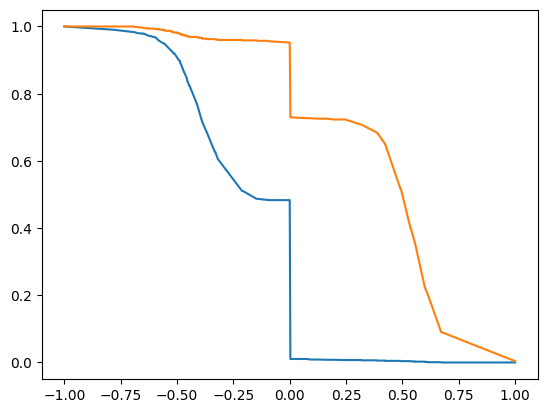

In [82]:
plt.plot(thresholds, fpr)
plt.plot(thresholds, tpr)

In [83]:
roc_auc

np.float64(0.9042068862573391)

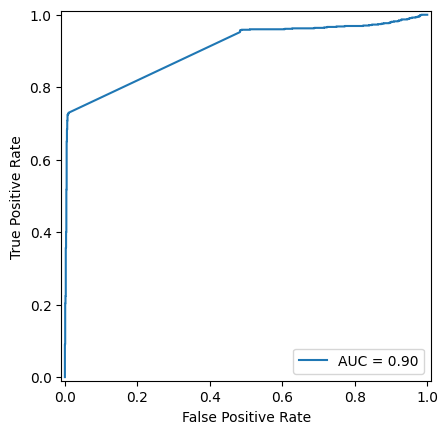

In [49]:
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [55]:
eval_df.filter(pl.col('te')>0).filter(pl.col('outreach') == 1)['churn'].describe()
# eval_df.filter(pl.col('outreach') == 1)['churn'].describe()

statistic,value
str,f64
"""count""",569.0
"""null_count""",0.0
"""mean""",0.991213
"""std""",0.09341
"""min""",0.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",1.0


In [33]:
eval_df.filter(pl.col('churn')==1).filter(pl.col('outreach') == 0)['te'].describe()

statistic,value
str,f64
"""count""",1248.0
"""null_count""",0.0
"""mean""",-0.207607
"""std""",0.236019
"""min""",-1.0
"""25%""",-0.40433
"""50%""",-0.192375
"""75%""",0.0
"""max""",0.67184


In [ ]:
dfs['claims']['diagnosis_date'].describe()

In [64]:
# train
from featurization import featurize_data
from data_ingestion import ingest_and_pre_process_data

train_dfs = ingest_and_pre_process_data(Path('./data/train'))
train_features_w_labels = featurize_data(train_dfs)

train_features = train_features_w_labels.drop(['member_id', 'churn', 'outreach'])

# T = outreach, Y = churn
cate_model = XLearner(models=LGBMClassifier(),)
                    #   propensity_model=LogisticRegression(solver='lbfgs', max_iter=10000))
cate_model.fit(Y=features_w_labels['churn'], T=features_w_labels['outreach'], X=features)

# Get conditional treatment effect
te = cate_model.effect(features)   # E[Y|T=1,X] - E[Y|T=0,X]


train_te = cate_model.effect(train_features)

[LightGBM] [Info] Number of positive: 1248, number of negative: 4768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 6016, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207447 -> initscore=-1.340385
[LightGBM] [Info] Start training from score -1.340385
[LightGBM] [Info] Number of positive: 773, number of negative: 3211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194026 -> initscore=-1.424059
[LightGBM] 

/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 37
[LightGBM] [Info] Start training from score -3.812705
[LightGBM] [Info] Start training from score -0.224776
[LightGBM] [Info] Start training from score -1.719159


/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exer

In [67]:
# train

train_eval_df = pl.DataFrame({'te': train_te, 
                        'member_id': train_features_w_labels['member_id'],
                        'outreach': train_features_w_labels['outreach'],
                        'churn': train_features_w_labels['churn'],})

train_fpr, train_tpr, train_thresholds = roc_curve(train_eval_df.filter(pl.col('churn')==1)['outreach'], 
                                 train_eval_df.filter(pl.col('churn')==1)['te'])
roc_auc = auc(train_fpr, train_tpr)

roc_auc

np.float64(0.5009868311938169)

In [69]:
train_features_w_labels

member_id,signup_date,churn,outreach,dx_count_A09,dx_count_Z71.3,dx_count_I10,dx_count_E11.9,dx_count_K21.9,dx_count_R51,dx_count_B34.9,dx_count_J00,dx_count_M54.5,dx_count_H10.9,first_dx_dt_A09,first_dx_dt_Z71.3,first_dx_dt_I10,first_dx_dt_E11.9,first_dx_dt_K21.9,first_dx_dt_R51,first_dx_dt_B34.9,first_dx_dt_J00,first_dx_dt_M54.5,first_dx_dt_H10.9,last_dx_dt_A09,last_dx_dt_Z71.3,last_dx_dt_I10,last_dx_dt_E11.9,last_dx_dt_K21.9,last_dx_dt_R51,last_dx_dt_B34.9,last_dx_dt_J00,last_dx_dt_M54.5,last_dx_dt_H10.9,wv_count,first_wv_dt,last_wv_dt,au_count,first_au_dt,last_au_dt
i64,datetime[μs],i64,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,u32,f64,f64
1,2024-04-12 00:00:00,0,0,0,2,1,1,0,0,0,4,1,0,0.0,7.0,4.0,7.0,0.0,0.0,0.0,15.0,15.0,0.0,0.0,2.0,4.0,7.0,0.0,0.0,0.0,3.0,15.0,0.0,2,13.0,1.0,6,13.0,1.0
2,2025-03-11 00:00:00,0,0,0,2,2,3,1,1,0,0,0,0,0.0,10.0,13.0,14.0,10.0,13.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,8.0,10.0,13.0,0.0,0.0,0.0,0.0,8,14.0,4.0,10,13.0,1.0
3,2024-09-27 00:00:00,0,0,0,0,0,1,1,0,0,0,2,0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,13.0,0.0,23,14.0,1.0,9,14.0,3.0
4,2024-04-16 00:00:00,1,0,1,0,3,0,0,0,0,1,0,0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,7,14.0,2.0,10,14.0,2.0
5,2024-03-12 00:00:00,0,1,0,1,1,2,1,0,0,0,2,0,0.0,10.0,10.0,10.0,8.0,0.0,0.0,0.0,3.0,0.0,0.0,10.0,10.0,8.0,8.0,0.0,0.0,0.0,2.0,0.0,6,10.0,2.0,10,14.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9996,2024-09-02 00:00:00,0,0,1,3,0,1,0,1,2,1,0,0,13.0,10.0,0.0,7.0,0.0,13.0,11.0,5.0,0.0,0.0,13.0,9.0,0.0,7.0,0.0,13.0,4.0,5.0,0.0,0.0,13,14.0,2.0,8,11.0,1.0
9997,2024-02-07 00:00:00,0,0,0,1,0,2,1,1,0,0,0,0,0.0,2.0,0.0,14.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11.0,7.0,2.0,0.0,0.0,0.0,0.0,4,10.0,5.0,11,13.0,2.0
9998,2024-09-01 00:00:00,0,0,0,2,0,0,2,1,2,4,1,2,0.0,8.0,0.0,0.0,13.0,2.0,14.0,9.0,10.0,13.0,0.0,5.0,0.0,0.0,4.0,2.0,8.0,2.0,10.0,9.0,3,12.0,4.0,12,14.0,4.0


In [ ]:
# test

test_dfs = ingest_and_pre_process_data(Path('./data/test'))
test_features_w_labels = featurize_data(test_dfs)

test_features = test_features_w_labels.drop(['member_id', 'churn', 'outreach'])

test_te = cate_model.effect(test_features)

/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# test

test_eval_df = pl.DataFrame({'te': test_te, 
                        'member_id': test_features_w_labels['member_id'],
                        'outreach': test_features_w_labels['outreach'],
                        'churn': test_features_w_labels['churn'],})

test_fpr, test_tpr, test_thresholds = roc_curve(test_eval_df.filter(pl.col('churn')==0)['outreach'], 
                                 test_eval_df.filter(pl.col('churn')==0)['te'])
roc_auc = auc(test_fpr, test_tpr)

roc_auc

np.float64(0.5006086149245393)

In [84]:
features_w_labels

member_id,churn,outreach,signup_date_dt,dx_count_K21.9,dx_count_R51,dx_count_H10.9,dx_count_M54.5,dx_count_B34.9,dx_count_I10,dx_count_Z71.3,dx_count_E11.9,dx_count_A09,dx_count_J00,first_dx_dt_K21.9,first_dx_dt_R51,first_dx_dt_H10.9,first_dx_dt_M54.5,first_dx_dt_B34.9,first_dx_dt_I10,first_dx_dt_Z71.3,first_dx_dt_E11.9,first_dx_dt_A09,first_dx_dt_J00,last_dx_dt_K21.9,last_dx_dt_R51,last_dx_dt_H10.9,last_dx_dt_M54.5,last_dx_dt_B34.9,last_dx_dt_I10,last_dx_dt_Z71.3,last_dx_dt_E11.9,last_dx_dt_A09,last_dx_dt_J00,wv_count,first_wv_dt,last_wv_dt,au_count,first_au_dt,last_au_dt
i64,i64,i64,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,u32,f64,f64
1,0,0,460,0,0,0,1,0,1,2,1,0,4,0.0,0.0,0.0,15.0,0.0,4.0,7.0,7.0,0.0,15.0,0.0,0.0,0.0,15.0,0.0,4.0,2.0,7.0,0.0,3.0,2,13.0,1.0,6,13.0,1.0
2,0,0,127,1,1,0,0,0,2,2,3,0,0,10.0,13.0,0.0,0.0,0.0,13.0,10.0,14.0,0.0,0.0,10.0,13.0,0.0,0.0,0.0,3.0,9.0,8.0,0.0,0.0,8,14.0,4.0,10,13.0,1.0
3,0,0,292,1,0,0,2,0,0,0,1,0,0,3.0,0.0,0.0,14.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,13.0,0.0,0.0,0.0,2.0,0.0,0.0,23,14.0,1.0,9,14.0,3.0
4,1,0,456,0,0,0,0,0,3,0,0,1,1,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,9.0,7,14.0,2.0,10,14.0,2.0
5,0,1,491,1,0,0,2,0,1,1,2,0,0,8.0,0.0,0.0,3.0,0.0,10.0,10.0,10.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,10.0,10.0,8.0,0.0,0.0,6,10.0,2.0,10,14.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9996,0,0,317,0,1,0,0,2,0,3,1,1,1,0.0,13.0,0.0,0.0,11.0,0.0,10.0,7.0,13.0,5.0,0.0,13.0,0.0,0.0,4.0,0.0,9.0,7.0,13.0,5.0,13,14.0,2.0,8,11.0,1.0
9997,0,0,525,1,1,0,0,0,0,1,2,0,0,7.0,2.0,0.0,0.0,0.0,0.0,2.0,14.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,2.0,11.0,0.0,0.0,4,10.0,5.0,11,13.0,2.0
9998,0,0,318,2,1,2,1,2,0,2,0,0,4,13.0,2.0,13.0,10.0,14.0,0.0,8.0,0.0,0.0,9.0,4.0,2.0,9.0,10.0,8.0,0.0,5.0,0.0,0.0,2.0,3,12.0,4.0,12,14.0,4.0
